<a href="https://colab.research.google.com/github/BChun11/DATA3001/blob/main/DATA3001_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib
import lightgbm as lgb

from scipy.stats import randint, uniform
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, roc_auc_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [8]:
# Download all the files into google colab environment
!git clone https://github.com/nokuik/KDDI-IoT-2019.git

Cloning into 'KDDI-IoT-2019'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 42 (delta 1), reused 9 (delta 1), pack-reused 33
Receiving objects: 100% (42/42), 776.84 MiB | 29.35 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (31/31), done.


In [9]:
# List all '.tar.gz files in ipfix directory
%cd KDDI-IoT-2019
%cd ipfix
!ls *.tar.gz

/content/KDDI-IoT-2019/ipfix/KDDI-IoT-2019
/content/KDDI-IoT-2019/ipfix/KDDI-IoT-2019/ipfix
 amazon_echo_gen2.tar.gz		        nature_remo.tar.gz
 au_network_camera.tar.gz		        panasonic_doorphone.tar.gz
 au_wireless_adapter.tar.gz		        philips_hue_bridge.tar.gz
 bitfinder_awair_breathe_easy.tar.gz	       'planex_camera_one_shot!.tar.gz'
 candy_house_sesami_wi-fi_access_point.tar.gz   planex_smacam_outdoor.tar.gz
 irobot_roomba.tar.gz			        planex_smacam_pantilt.tar.gz
 jvc_kenwood_cu-hb1.tar.gz		        powerelectric_wi-fi_plug.tar.gz
 jvc_kenwood_hdtv_ip_camera.tar.gz	        qrio_hub.tar.gz
 line_clova_wave.tar.gz			        sony_network_camera.tar.gz
 link_japan_eremote.tar.gz		        sony_smart_speaker.tar.gz
 mouse_computer_room_hub.tar.gz		        xiaomi_mijia_led.tar.gz


In [10]:
# List all tar.gz files and store them in a variable
files = !ls -1 *.tar.gz

# Extract each tar.gz file
for file in files:
    print(f"Extract {file} ")
    !tar -xzvf {file}

Extract amazon_echo_gen2.tar.gz 
amazon_echo_gen2.json
Extract au_network_camera.tar.gz 
au_network_camera.json
Extract au_wireless_adapter.tar.gz 
au_wireless_adapter.json
Extract bitfinder_awair_breathe_easy.tar.gz 
bitfinder_awair_breathe_easy.json
Extract candy_house_sesami_wi-fi_access_point.tar.gz 
candy_house_sesami_wi-fi_access_point.json
Extract irobot_roomba.tar.gz 
irobot_roomba.json
Extract jvc_kenwood_cu-hb1.tar.gz 
jvc_kenwood_cu-hb1.json
Extract jvc_kenwood_hdtv_ip_camera.tar.gz 
jvc_kenwood_hdtv_ip_camera.json
Extract line_clova_wave.tar.gz 
line_clova_wave.json
Extract link_japan_eremote.tar.gz 
link_japan_eremote.json
Extract mouse_computer_room_hub.tar.gz 
mouse_computer_room_hub.json
Extract nature_remo.tar.gz 
nature_remo.json
Extract panasonic_doorphone.tar.gz 
panasonic_doorphone.json
Extract philips_hue_bridge.tar.gz 
philips_hue_bridge.json
Extract 'planex_camera_one_shot!.tar.gz' 
planex_camera_one_shot!.json
Extract planex_smacam_outdoor.tar.gz 
planex_smacam

In [11]:
# Print the current working directory
print("Current Working Directory:", os.getcwd())

# List the contents of the current working directory
print("Contents of Current Directory:", os.listdir())

!cd

Current Working Directory: /content/KDDI-IoT-2019/ipfix/KDDI-IoT-2019/ipfix
Contents of Current Directory: ['jvc_kenwood_cu-hb1.json', 'sony_network_camera.json', 'i-o_data_qwatch.tar.gz00', 'sony_smart_speaker.tar.gz', 'amazon_echo_gen2.tar.gz', 'xiaomi_mijia_led.tar.gz', 'sony_smart_speaker.json', 'link_japan_eremote.tar.gz', 'planex_smacam_pantilt.tar.gz', 'philips_hue_bridge.json', 'amazon_echo_gen2.json', 'planex_smacam_outdoor.json', 'jvc_kenwood_hdtv_ip_camera.json', 'irobot_roomba.tar.gz', 'planex_smacam_outdoor.tar.gz', 'sony_network_camera.tar.gz', 'xiaomi_mijia_led.json', 'nature_remo.json', 'powerelectric_wi-fi_plug.tar.gz', 'bitfinder_awair_breathe_easy.tar.gz', 'bitfinder_awair_breathe_easy.json', 'powerelectric_wi-fi_plug.json', 'google_home_gen1.tar.gz01', 'qrio_hub.tar.gz', 'au_network_camera.json', 'planex_smacam_pantilt.json', 'philips_hue_bridge.tar.gz', 'link_japan_eremote.json', 'planex_camera_one_shot!.json', 'irobot_roomba.json', 'line_clova_wave.tar.gz', 'sony_

In [12]:
# Code to generate distinct tables for each json file using a limited subset

# Define the directory where the JSON files are located
json_directory = '/content/KDDI-IoT-2019/ipfix'

# Get the list of all JSON files in the directory
json_files = [f for f in os.listdir(json_directory) if f.endswith('.json')]

# Create distinct tables for each json file
tables = {}
for json_file in json_files:
    # strip .json suffix from device names
    device_name = json_file.split('.')[0]
    # Construct the full path to the JSON file
    json_path = os.path.join(json_directory, json_file)

    # Read the JSON file into a DataFrame, normalize the 'flows' column, and get the first 1000 rows
    df = pd.json_normalize(pd.read_json(json_path, lines=True, nrows=1000)['flows'])

    # Label the DataFrame with the device name
    df['Device'] = device_name
    tables[device_name] = df

# Concatenate all the Dataframes in the tables dictionary into a single Dataframe
df = pd.concat(tables.values(), ignore_index=True)
df.head()


,flowStartMilliseconds,flowEndMilliseconds,flowDurationMilliseconds,reverseFlowDeltaMilliseconds,protocolIdentifier,sourceIPv4Address,sourceTransportPort,packetTotalCount,octetTotalCount,flowAttributes,...,reverseNonEmptyPacketCount,reverseDataByteCount,reverseAverageInterarrivalTime,reverseFirstNonEmptyPacketSize,reverseLargePacketCount,reverseMaxPacketSize,reverseStandardDeviationPayloadLength,reverseStandardDeviationInterarrivalTime,reverseBytesPerPacket,Device
0,2019-06-25 08:36:16.241,2019-06-25 08:36:17.427,1.186,0.178,6,192.168.1.186,55656,14,1841,00,...,7.0,6458.0,100.0,1402.0,6.0,1402.0,565.0,102.0,922.0,jvc_kenwood_cu-hb1
1,2019-06-25 08:36:33.530,2019-06-25 08:36:34.688,1.158,0.172,6,192.168.1.186,56823,14,1841,00,...,7.0,6458.0,98.0,1402.0,6.0,1402.0,565.0,100.0,922.0,jvc_kenwood_cu-hb1
2,2019-06-25 08:36:53.166,2019-06-25 08:36:54.340,1.174,0.178,6,192.168.1.186,55658,14,1841,00,...,7.0,6458.0,110.0,1402.0,6.0,1402.0,565.0,100.0,922.0,jvc_kenwood_cu-hb1
3,2019-06-25 08:37:12.861,2019-06-25 08:37:14.047,1.186,0.176,6,192.168.1.186,55659,14,1841,00,...,7.0,6458.0,112.0,1402.0,6.0,1402.0,565.0,103.0,922.0,jvc_kenwood_cu-hb1
4,2019-06-25 08:37:32.566,2019-06-25 08:37:33.723,1.157,0.173,6,192.168.1.186,56826,14,1841,00,...,7.0,6458.0,82.0,1402.0,6.0,1402.0,565.0,101.0,922.0,jvc_kenwood_cu-hb1


In [13]:
"""# Reference: https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 @ARJANGROEN

 Reduce Memory Usage
  This code is used to reduce memory usage of our dataframe useful when running
  large datasets by reducing the size of the properties of the dataset by selecting
  smaller datatypes


def reduce_memory_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage became: ",mem_usg," MB")

    return df"""

'# Reference: https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 @ARJANGROEN\n\n Reduce Memory Usage\n  This code is used to reduce memory usage of our dataframe useful when running\n  large datasets by reducing the size of the properties of the dataset by selecting\n  smaller datatypes\n\n\ndef reduce_memory_usage(df):\n    start_mem = df.memory_usage().sum() / 1024**2\n    print(\'Memory usage of dataframe is {:.2f} MB\'.format(start_mem))\n\n    for col in df.columns:\n        col_type = df[col].dtype.name\n        if ((col_type != \'datetime64[ns]\') & (col_type != \'category\')):\n            if (col_type != \'object\'):\n                c_min = df[col].min()\n                c_max = df[col].max()\n\n                if str(col_type)[:3] == \'int\':\n                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:\n                        df[col] = df[col].astype(np.int8)\n                    elif c_min > np.iinfo(np.int16).min and c_max

### Data Transformation

In [14]:
# Define the list of columns to be dropped
drop_columns = ['flowStartMilliseconds',
                'flowEndMilliseconds',
                'sourceMacAddress',
                'destinationMacAddress'
]

# Drop the columns from the dataset
df = df.drop(columns=drop_columns)

In [15]:
# Check number of categories in IP address (Concerns of Increase in dimensionality)
df['sourceIPv4Address'].unique()

array(['192.168.1.186', '52.54.10.4', '192.168.1.1', '52.4.45.89',
       '172.217.161.68', '216.58.197.228', '172.217.26.36',
       '172.217.25.228', '172.217.24.132', '172.217.161.36',
       '172.217.26.4', '216.58.197.164', '172.217.25.100',
       '172.217.31.132', '192.168.1.200', '192.168.1.231',
       '172.217.25.202', '8.8.8.8', '172.217.31.142', '192.168.1.26',
       '192.168.1.236', '192.168.1.42', '13.33.9.142',
       'fe80::4eef:c0ff:fe17:e042', '99.84.139.128', '99.84.62.160',
       '52.119.161.177', '13.33.95.222', '54.230.175.252',
       '52.119.164.210', '54.240.188.172', '13.249.171.235',
       '52.119.168.147', '99.84.63.119', '192.168.1.158', '192.168.1.38',
       '192.168.1.20', '47.88.175.190', '192.168.1.225', '3.86.45.125',
       '54.209.101.146', '18.204.1.216', '34.202.82.197', '192.168.1.2',
       '34.213.4.245', '35.203.134.251', '52.40.15.135', '35.197.82.39',
       '192.168.1.35', '210.140.77.191', '192.168.1.140', '192.168.1.17',
       '::', '

In [16]:
df['destinationIPv4Address'].unique()

array(['52.54.10.4', '52.4.45.89', '192.168.1.1', '192.168.1.186',
       '172.217.161.68', '216.58.197.228', '172.217.26.36',
       '172.217.25.228', '172.105.236.23', '139.162.61.175',
       '239.255.255.250', '172.217.24.132', '172.217.161.36',
       '172.217.26.4', '216.58.197.164', '172.217.25.100',
       '172.217.31.132', '192.168.1.200', '8.8.8.8', '172.217.31.180',
       '192.168.1.231', '172.217.161.35', '172.217.26.14',
       '216.239.35.12', '172.217.25.202', '216.239.35.0',
       '172.217.31.142', '108.177.125.188', '74.125.203.188',
       '224.0.0.251', '172.217.24.142', '172.217.26.10', '216.239.35.4',
       '172.217.31.174', '216.239.35.8', '172.217.161.74',
       '216.58.197.244', '172.217.31.163', '172.217.25.78',
       '192.168.1.26', '52.213.192.178', '54.76.81.242', '34.90.173.53',
       '34.90.171.169', '192.168.1.236', '52.119.168.148',
       '52.216.129.35', '192.168.1.42', '54.231.33.171', '3.88.203.170',
       '52.216.162.227', '54.227.93.14', '13

In [17]:
"""
  Encode and transform categorical values since Decision Tree & Random Forest can't handle non-numeric
  categorical data directly
"""

"""# Ordinal encoding for IP addresses
def ip_to_ordinal(df, col_name):
    # Generate unique codes for each unique IP address
    codes, uniques = pd.factorize(df[col_name])
    df[col_name] = codes
    return df

df = ip_to_ordinal(df, 'sourceIPv4Address')
df = ip_to_ordinal(df, 'destinationIPv4Address')"""

# Frequency encoding for IP addresses
def frequency_encoding(df, col_name):
    # Count the frequency of each unique IP address
    freq_map = df[col_name].value_counts().to_dict()
    df[col_name] = df[col_name].map(freq_map)
    return df

df = frequency_encoding(df, 'sourceIPv4Address')
df = frequency_encoding(df, 'destinationIPv4Address')

# Converting hex to int
for col in ['tcpSequenceNumber', 'reverseTcpSequenceNumber', 'vlanId', 'ipClassOfService']:
    df[col] = df[col].apply(lambda x: int(x, 16))

# One-hot encoding for categorical attributes without ordinal relationship
one_hot_cols = ['flowAttributes', 'initialTCPFlags', 'unionTCPFlags', 'reverseInitialTCPFlags',
                'reverseUnionTCPFlags', 'reverseFlowAttributes', 'collectorName', 'flowEndReason']

df = pd.get_dummies(df, columns=one_hot_cols)

# Label encoding for  the attributes that can be label encoded without any issues
label_cols = ['firstEightNonEmptyPacketDirections', 'Device']
label_encoders = {}

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [18]:
# Separate the Device column as label
labels_df = df['Device'].copy()

# Drop the Device column from the original DataFrame
df = df.drop(columns=['Device'])

X = df
y = labels_df

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Applying the Decision Tree and Random Forest Algorithm

#### Assessing the Performance of the Multi-Class Classifier
- The print_score function is designmed to evaluate a multi-class classifier's performance using F1 score and ROC-AUC curve.
- We're using the 'weighted' average for the F1 score and 'ovr' (One-vs-rest) approach for the multi-class ROC-AUC.

In [19]:
# Evaluate how well a classifier model is performing on the training data
def print_score(cls, X_train, y_train, X_test, y_test, train=True):
    if train:
        X, y = X_train, y_train
        data_type = "Train"
    else:
        X, y = X_test, y_test
        data_type = "Test"

    # The model 'cls' uses the features X to make predictions
    pred_y = cls.predict(X)
    prob = cls.predict_proba(X)

    # Compute 'weighted' F1-Score
    f1Score = f1_score(y, pred_y, average='weighted')
    # Compute ROC-AUC for each class using 'One-vs-rest'
    roc_auc = roc_auc_score(y, prob, average='weighted', multi_class='ovr')

    # Print results
    print(f"=== {data_type} Data ===")
    print(f"Weighted F1 Score = {f1Score:.4f}\n")
    print(f'ROC-AUC score: {roc_auc:.4f}\n')
    print("_______________________________________________")
    print(classification_report(y, pred_y))
    print("\n")

Treating missing values: Using Imputation to fill in the missing values

In [20]:
# Using imputation to fill in the missing values
# Create impute object
imputer = SimpleImputer()

# Fit imputer on training data
imputer.fit(X_train)

# Impute training data
X_train = imputer.transform(X_train)

# Impute the test data
X_test = imputer.transform(X_test)

### Decision Tree Classifier

In [21]:
# Create Decision Tree Classifier object
dec_tree = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
dec_tree.fit(X_train, y_train)

# Print model performance on training data
print_score(dec_tree, X_train, y_train, X_test, y_test, train=True)

# Print model performance on test data
print_score(dec_tree, X_train, y_train, X_test, y_test, train=False)

=== Train Data ===
Weighted F1 Score = 1.0000

ROC-AUC score: 1.0000

_______________________________________________
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       790
           1       1.00      1.00      1.00       805
           2       1.00      1.00      1.00       795
           3       1.00      1.00      1.00       798
           4       1.00      1.00      1.00       806
           5       1.00      1.00      1.00       806
           6       1.00      1.00      1.00       820
           7       1.00      1.00      1.00       794
           8       1.00      1.00      1.00       786
           9       1.00      1.00      1.00       802
          10       1.00      1.00      1.00       814
          11       1.00      1.00      1.00       775
          12       1.00      1.00      1.00       797
          13       1.00      1.00      1.00       781
          14       1.00      1.00      1.00       799
          15     

### Random Forest

### Random Forest Hyperparameter tuning

In [22]:
# Defining the hyperparameters
param_rf = {
    'n_estimators': randint(50, 250),
    'max_depth': [None] + list(randint(5, 50).rvs(10)),
    'min_samples_split': randint(2, 50),
    'min_samples_leaf': randint(1, 50),
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

# Initializing the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initializing the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_rf,
                                   n_iter=10, scoring='f1_weighted',
                                   cv=5, random_state=42)

# Fit the RandomizedSearchCV onto the train dataset
random_search.fit(X_train, y_train)

# Print the best parameters from the RandomizedSearchCV
random_cv = random_search.best_estimator_
print(f"Best parameters: {random_search.best_params_}")


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best parameters: {'bootstrap': False, 'class_weight': None, 'max_depth': 45, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 25, 'n_estimators': 207}


In [32]:
# Evaluate the best Random Forest model for the train dataset
print_score(random_cv, X_train, y_train, X_test, y_test, train=True)

# Evaluate the best Random Forest model for the test dataset
print_score(random_cv, X_train, y_train, X_test, y_test, train=False)

=== Train Data ===
Weighted F1 Score = 0.9851

ROC-AUC score: 0.9998

_______________________________________________
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       790
           1       1.00      0.99      1.00       805
           2       0.95      0.94      0.95       795
           3       1.00      1.00      1.00       798
           4       1.00      1.00      1.00       806
           5       1.00      1.00      1.00       806
           6       1.00      0.95      0.97       820
           7       1.00      1.00      1.00       794
           8       0.95      1.00      0.97       786
           9       1.00      1.00      1.00       802
          10       1.00      1.00      1.00       814
          11       0.99      1.00      0.99       775
          12       1.00      0.94      0.97       797
          13       0.87      0.98      0.93       781
          14       1.00      1.00      1.00       799
          15     

### Random Forest Feature Importance
Lets try look at the feature importances of the random forest

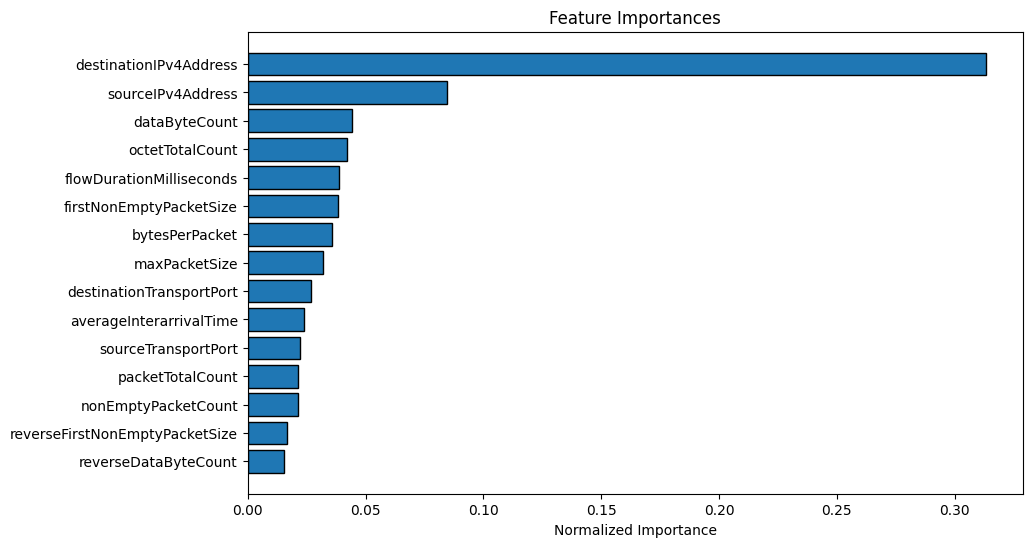

In [24]:
# Reference: https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction

# Function extracts feature importances from the Random Forest Model
def extract_feature_importances(model, feature_names):
    return pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    })

# Function plots feature importances returned by the model
def plot_feature_importances(df, n_features=15):
    """
    Plot importances returned by a model.

    Returns DataFrame: Feature importances sorted by importance from
    (highest to lowest) with a column for normalized importance.
    """
    # Sort and reset index
    df = df.sort_values('importance', ascending=False).reset_index(drop=True)

    # Normalize the importances
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Plot
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()

    ax.barh(df['feature'][:n_features][::-1],
            df['importance_normalized'][:n_features][::-1],
            align='center', edgecolor='k')

    ax.set_yticks(range(n_features))
    ax.set_yticklabels(df['feature'][:n_features][::-1])

    plt.xlabel('Normalized Importance')
    plt.title('Feature Importances')
    plt.show()

    return df

feature_importances = extract_feature_importances(random_cv, X.columns)
feature_importances_sorted = plot_feature_importances(feature_importances)


### Logistic Regression

In [25]:
# Scale Features in Logistic Regression
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler only on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Use the scaler to transform the test data
X_test_scaled = scaler.transform(X_test)

In [26]:
# Initialize the logistic regression model
logistic_reg = LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear', random_state=42)

# Train the logistic regression model
logistic_reg.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000, multi_class='ovr', random_state=42,
                   solver='liblinear')

In [27]:
# Evaluate the logistic regression model on training data
print_score(logistic_reg, X_train_scaled, y_train, X_test_scaled, y_test, train=True)

# Evaluate the logistic regression model on test data
print_score(logistic_reg, X_train_scaled, y_train, X_test_scaled, y_test, train=False)

=== Train Data ===
Weighted F1 Score = 0.4491

ROC-AUC score: 0.9111

_______________________________________________
              precision    recall  f1-score   support

           0       0.92      0.41      0.57       790
           1       0.33      0.12      0.18       805
           2       0.62      0.96      0.75       795
           3       0.18      0.36      0.24       798
           4       0.21      1.00      0.35       806
           5       0.15      0.07      0.09       806
           6       0.70      0.59      0.64       820
           7       0.30      0.34      0.32       794
           8       0.49      0.17      0.25       786
           9       1.00      0.03      0.07       802
          10       1.00      1.00      1.00       814
          11       0.82      0.04      0.07       775
          12       0.81      0.61      0.69       797
          13       0.91      0.22      0.35       781
          14       1.00      1.00      1.00       799
          15     

### LightGBM

In [37]:
# Defining the parameters for LightGBM
lightgbm_param = {
    "objective": ["multiclass"],
    "boosting_type": ["gbdt"],
    "num_class": [len(y.unique())],
    "metric": ["multi_logloss"],
    "learning_rate": [0.01, 0.05, 0.1],
    "num_leaves": randint(10, 50).rvs(10),
    "max_depth": [-1] + list(randint(5, 50).rvs(10)),
    "feature_fraction": [0.7, 0.8, 0.9, 1.0]
}

lgbm_clf = lgb.LGBMClassifier()
# Initialising RandomizedSearchCV
random_search_lgbm = RandomizedSearchCV(estimator=lgbm_clf,
                                        param_distributions=lightgbm_param,
                                        n_iter=10,
                                        scoring='f1_weighted',
                                        cv=5,
                                        random_state=42)

# Fitting the RandomizedSearchCV onto the train dataset
random_search_lgbm.fit(X_train, y_train)

# Best parameters from the RandomizedSearchCV
best_lgbm = random_search_lgbm.best_estimator_

print(f"Value of the Best parameters: {random_search_lgbm.best_params_}")


Streaming output truncated to the last 5000 lines.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4239
[LightGBM] [Info] Number of data points in the train set: 14080, number of used features: 61
[LightGBM] [Info] Start training from score -3.103621
[LightGBM] [Info] Start training from score -3.084812
[LightGBM] [Info] Start training from score -3.097312
[LightGBM] [Info] Start training from score -3.092606
[LightGBM] [Info] Start training from score -3.084812
[LightGBM] [Info] Start training from score -3.083260
[LightGBM] [Info] Start training from score -3.066350
[LightGBM] [Info] Start training from score -3.098886
[LightGBM] [Info] Start training from score -3.108379
[LightGBM] [Info] Start training from score -3.089481
[LightGBM] [Info] Start training from score -3.074001
[LightGBM] [Info] Start training from score -3.122791
[LightGBM] [Info] Start training from score -3.09417

In [38]:
# Evaluate how well a classifier model is performing on the training data
def print_score(cls, X_train, y_train, X_test, y_test, train=True):
    if train:
        X, y = X_train, y_train
        data_type = "Train"
    else:
        X, y = X_test, y_test
        data_type = "Test"

    # If the classifier is a LightGBM, predict() gives probabilities directly
    if isinstance(cls, lgb.basic.Booster):
        prob = cls.predict(X)
        pred_y = [list(row).index(max(row)) for row in prob]
    else:
        pred_y = cls.predict(X)
        prob = cls.predict_proba(X)

    # Compute 'weighted' F1-Score
    f1Score = f1_score(y, pred_y, average='weighted')
    # Compute ROC-AUC for each class using 'One-vs-rest'
    roc_auc = roc_auc_score(y, prob, average='weighted', multi_class='ovr')

    # Print results
    print(f"=== {data_type} Data ===")
    print(f"Weighted F1 Score = {f1Score:.4f}\n")
    print(f'ROC-AUC score: {roc_auc:.4f}\n')
    print("_______________________________________________")
    print(classification_report(y, pred_y))
    print("\n")


In [39]:
# Evaluate the best LightGBM model for the train dataset
print_score(best_lgbm, X_train, y_train, X_test, y_test, train=True)

# Evaluate the best LightGBM model for the test dataset
print_score(best_lgbm, X_train, y_train, X_test, y_test, train=False)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
=== Train Data ===
Weighted F1 Score = 1.0000

ROC-AUC score: 1.0000

_______________________________________________
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       790
           1       1.00      1.00      1.00       805
           2       1.00      1.00      1.00       795
           3       1.00      1.00      1.00       798
           4       1.00      1.00      1.00       806
           5       1.00      1.00      1.00       806
           6       1.00      1.00      1.00       820
           7       1.00      1.00      1.00       794
           8       1.00      1.00      1.00       786
           9       1.00      1.00      1.00       802
          10       1.00      1.00      

## XGBoost

In [41]:
# Defining the hyperparameters for XGBoost model
xgb_param = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": randint(50, 250),
    "max_depth": [None] + list(randint(5, 50).rvs(10)),
    "min_child_weight": randint(1, 10),
    "gamma": uniform(0, 0.5),
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": uniform(0.5, 0.5),
    "objective": ['multi:softmax'],
    "num_class": [len(y.unique())],
    "eval_metric": ["mlogloss"],
    "seed": [42]
}

# Initialising the XGBoost Classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False)

# Initialising the RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(estimator=xgb_clf,
                                       param_distributions=xgb_param,
                                       n_iter=10,
                                       scoring='f1_weighted',
                                       cv=5,
                                       random_state=42)

# Fit the RandomizedSearchCV on to the train dataset
random_search_xgb.fit(X_train, y_train)

# Best parameters from the RandomizedSearchCV for XGBoost
best_xgb = random_search_xgb.best_estimator_
print(f"Value of Best parameters: {random_search_xgb.best_params_}")

Best parameters: {'colsample_bytree': 0.7816441089227697, 'eval_metric': 'mlogloss', 'gamma': 0.19270825126995805, 'learning_rate': 0.05, 'max_depth': 15, 'min_child_weight': 2, 'n_estimators': 133, 'num_class': 22, 'objective': 'multi:softmax', 'seed': 42, 'subsample': 0.6205127330130058}


In [42]:
# Evaluate the best XGBoost model for the train dataset
print_score(best_xgb, X_train, y_train, X_test, y_test, train=True)

# Evaluate the best XGBoost model for the test dataset
print_score(best_xgb, X_train, y_train, X_test, y_test, train=False)

=== Train Data ===
Weighted F1 Score = 0.9998

ROC-AUC score: 1.0000

_______________________________________________
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       790
           1       1.00      1.00      1.00       805
           2       1.00      1.00      1.00       795
           3       1.00      1.00      1.00       798
           4       1.00      1.00      1.00       806
           5       1.00      1.00      1.00       806
           6       1.00      1.00      1.00       820
           7       1.00      1.00      1.00       794
           8       1.00      1.00      1.00       786
           9       1.00      1.00      1.00       802
          10       1.00      1.00      1.00       814
          11       1.00      1.00      1.00       775
          12       1.00      1.00      1.00       797
          13       1.00      1.00      1.00       781
          14       1.00      1.00      1.00       799
          15     